# Axelrod model  

In [1]:
import matplotlib.pyplot as plt

In [2]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
from mesa.time import RandomActivation

import numpy as np
import networkx as nx
import random

from tqdm.notebook import tqdm

### Difference Measurement

This is our metric to check whether the model leads to homogenized state of traits or remain  relatively diverse.

$difference = \frac{1}{n} \sum_{(i,j)\in Edges}|feature_i - feature_j|$

In [3]:
def f_difference(model):
    diff = 0
    conn = nx.edges(model.graph)
    for edge in conn:
        diff += np.mean(abs(model.schedule.agents[edge[0]].feature - model.schedule.agents[edge[1]].feature))
    return diff

### Defining the Agent and the Model

We will define the agent and the object model according to Mesa's framework. In this implementation, the action is done under the model's step instead of agent's step because it is simpler to just call one agent at a time using this interaction because the usual Mesa scheduler require every agent to be activated in each time step.

In [4]:
class axl_agent(Agent):
    '''Individual agent represented by a node in a network'''
    
    ## Initializing the agent.
    def __init__(self, unique_id, feat, trt, model):
        super().__init__(unique_id, model)
        self.feature = np.random.randint(low = 0, high = trt, size = feat)
    
    ## No content on agent's step.
    def step(self):
        return
    
class axl_model(Model):
    '''Model containing N agents connected in a network. Also change the value of agent here'''
    
    ##Initializing the model.
    def __init__(self, N, Graph, feat, trt):
        self.graph = Graph
        self.no_features = feat
        self.no_agents = N
        self.G = NetworkGrid(Graph)
        self.schedule = RandomActivation(self)
        
        ## Creating the agents.
        for i in range(self.no_agents):
            a = axl_agent(i, feat, trt, self)
            self.schedule.add(a)
        
        ## Creating collector for difference function defined above.
        self.datacollector = DataCollector(model_reporters = {"Difference" : f_difference})
    
    ## At each model step, they collect data by using the collector.
    def step(self):
        self.datacollector.collect(self)
        agent = random.choice(self.schedule.agents)
        neigh = self.schedule.agents[random.choice(self.G.get_neighbors(agent.unique_id))]
        prob = np.count_nonzero(agent.feature - neigh.feature)/self.no_features
        if np.random.rand() < prob:
            index = np.random.choice(np.nonzero(agent.feature - neigh.feature)[0])
            agent.feature[index] = neigh.feature[index]

### run the sim on ER graphs


In [5]:
features = 5
traits = 5
N = 100
P = 0.1
time = 3000
graph = nx.fast_gnp_random_graph(N, P)

In [6]:
model = axl_model(N, graph, features, traits)

In [7]:
for i in range(time):
    model.step()

<AxesSubplot:>

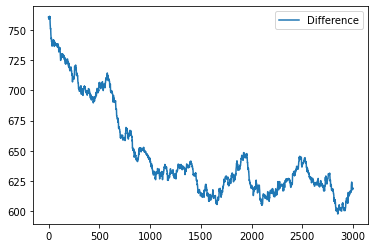

In [8]:
data = model.datacollector.get_model_vars_dataframe()
data.plot()

### Grid

In [9]:
def grid_layout(g):
    pos = {}
    L = np.sqrt(g.number_of_nodes())
    for n in g.nodes():
        pos[n] = [int(n/L), n%L]
    return pos;

In [10]:
features = 1
traits = 5
N = 20
P = 0.1
time = 10000
ws = {}
graph = nx.grid_2d_graph(N, N)
graph = nx.relabel_nodes(graph, dict(zip(graph.nodes, range(graph.number_of_nodes()))))
model = axl_model(N**2, graph, features, traits)
for i in tqdm(range(time)):
    model.step()
    if i%1000==0:
        ws[i] = []
        for j, agent in enumerate(model.schedule.agents):
            ws[i].append(agent.feature[0]);

  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:>

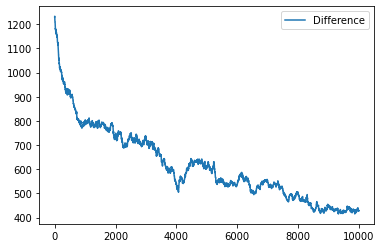

In [11]:
data = model.datacollector.get_model_vars_dataframe()
data.plot()


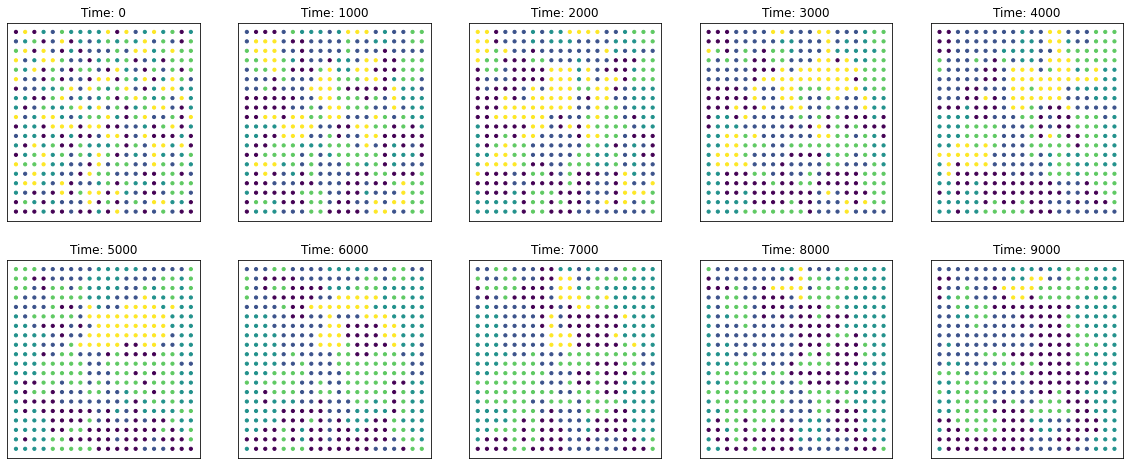

In [12]:
pos = grid_layout(graph) #nx.spectral_layout(graph)
fig = plt.figure(figsize=(20,8))

for i, k in enumerate(ws.keys()):
    plt.subplot(2, 5, i+1)   
    plt.title('Time: '+str(i*1000))
    nx.draw_networkx_nodes(graph, pos, node_size=10, node_color=[ws[k][x] for x in graph.nodes()])

### largest component of a certain attribute?

In [15]:
GCS = []
for t in ws:
    gcs = []
    for attr in np.unique(ws[t]):
        attr_subnodes = [i  for i,k in enumerate(ws[t]) if k==attr ]
        attr_subgraph = nx.subgraph(graph, attr_subnodes);
        gcs.append(len(list(nx.components.connected_components(attr_subgraph))[0]))
    GCS.append(np.max(gcs))

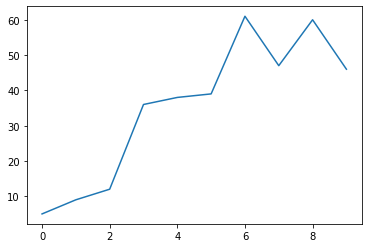

In [16]:
plt.plot(GCS)

## Homework:

- write your own Schellings model (on lattices! how would it look like on networks?)

https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation